## Регуляризация для логистической регрессии

Для примера рассмотрим данные об результатах тестирования чипов и задачу их классификации на нормальные и бракованные.

In [1]:
%pylab inline

import pandas as pd

microchip = pd.read_csv("microchip_test.csv", names=['Test1', 'Test2', 'Passed'])

X = microchip[['Test1', 'Test2']].values
y = microchip['Passed'].values

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Test2')

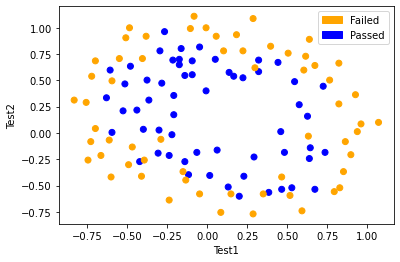

In [2]:
import seaborn as sns
import matplotlib.patches as mpatches

colors = microchip['Passed'].map({0: 'orange', 1: 'b'})
plt.scatter(x=microchip['Test1'], y=microchip['Test2'], c=colors)
red_patch = mpatches.Patch(color='orange', label='Failed')
blue_patch = mpatches.Patch(color='blue', label='Passed')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Test1')
plt.ylabel('Test2')

## Обучим модель логистической регрессии с полиномиальными признаками

In [3]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Accuracy on training set: 0.831


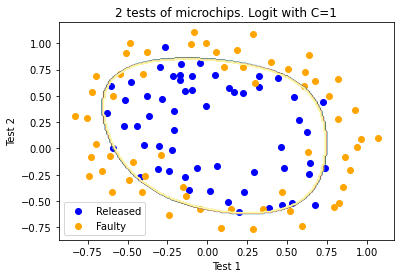

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

C = 1

logreg = LogisticRegression(penalty='l2', C=C, random_state=42)
logreg.fit(X_poly, y)

plot_boundary(logreg, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logreg.score(X_poly, y), 3))

## Задание

Подберите наилучшее значение коэффициента регуляризации C методом кросс-валидации. В качестве метрики используйте долю верных ответов (accuracy)

Accuracy on training set: 0.838983


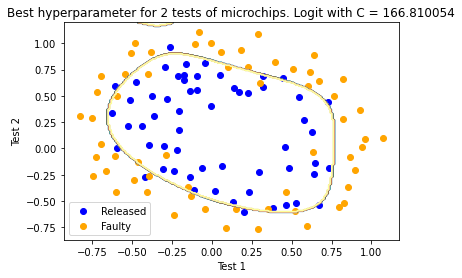

In [5]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(random_state=42 , cv = 5, max_iter = 1e3, scoring='accuracy').fit(X_poly, y)


plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('Best hyperparameter for 2 tests of microchips. Logit with C = %s' % round(clf.C_[0], 6))
plt.legend();

print("Accuracy on training set:", 
      round(clf.score(X_poly, y), 6))


# Построить коридор ошибки в зависимости от C

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

cv_scores = np.zeros((len(clf.Cs_), 5))
for i, c in enumerate(clf.Cs_):
    logreg = LogisticRegression(penalty='l2', C=c, random_state=0, max_iter = 1000)
    cv_score = cross_validate(logreg, X_poly, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores[i, : ] = cv_score['test_score']

Text(0.5, 1.0, 'Cross validation')

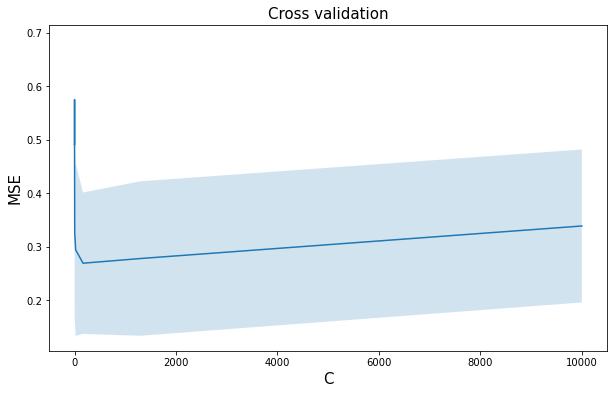

In [8]:
plt.figure(figsize=(10,6))
plt.plot(clf.Cs_, -cv_scores.mean(axis=1))
plt.fill_between(clf.Cs_,
                 -cv_scores.mean(axis=1) - cv_scores.std(axis=1),
                 -cv_scores.mean(axis=1) + cv_scores.std(axis=1),
                 alpha=0.2)
plt.xlabel('C', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Cross validation', fontsize=15)

Text(0.5, 1.0, 'Cross validation')

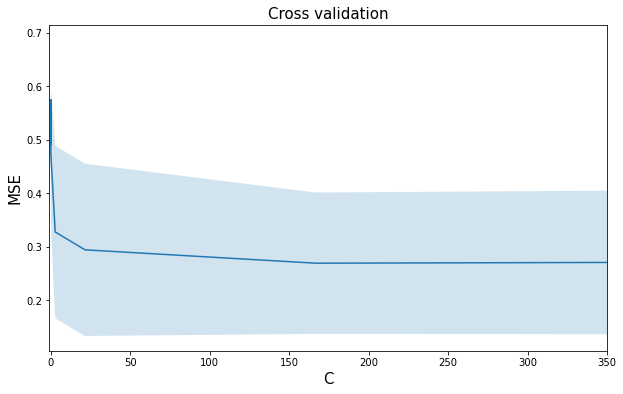

In [10]:
plt.figure(figsize=(10,6))
plt.plot(clf.Cs_, -cv_scores.mean(axis=1))
plt.fill_between(clf.Cs_,
                 -cv_scores.mean(axis=1) - cv_scores.std(axis=1),
                 -cv_scores.mean(axis=1) + cv_scores.std(axis=1),
                 alpha=0.2)
plt.xlim(-1, 350)
plt.xlabel('C', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Cross validation', fontsize=15)

# Вывод
Посредством кросс - валидации удалось найти оптимальный гиперпараметр C = 166,81. 
По графику квадартичной ошибки отлично видно, почему данное значение С - оптимальное. До данного значения коридор квадратичной ошибки достаточно широкий,а значение ошибки убывает, что говорит о **недообучении**.
После превышения оптимального значения, ошибка начинает расти, но без значительного изменения коридора ошибки, что говорит о **переобучении**